In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
from pandas_profiling import ProfileReport

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [104]:
df = pd.read_excel("./Biotech panel 1.xlsx", sheet_name = "PAD")
df.head()

,study ID,IL-33 (pg/ml),uPAR (pg/ml),CXCL6 (pg/ml),ESM-1 (pg/ml),SCF (pg/ml),TSG-14 (pg/ml),IL-2 (pg/ml),PCSK9 (pg/ml),RAGE (pg/ml),...,Plt,HbA1c,crp,HDL,Chol/ HDL ratio,LDL,non-HDL,glucose,glucose fasting,MRNno.
0,5,14.091162,557.896234,110.729424,1055.750683,116.074164,1333.413564,46.515919,69268.582453,3231.556933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82783
1,14,33.331707,2383.453789,128.812424,472.920153,107.254642,570.205218,93.976533,66247.932316,2459.595380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,799525
2,92,19.413896,922.174636,207.177434,983.060117,69.369572,1452.355327,59.580556,117311.334839,1455.813626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2089217
3,119,59.897453,2734.344683,645.989311,1323.804448,187.559274,1353.296620,134.53979,115404.072833,4621.795653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2736264
4,124,37.126933,4847.796709,268.216338,991.308486,140.609145,1423.928314,113.068512,137419.409806,2821.843801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2028463


In [105]:

proteins = ['IL-33 (pg/ml)', 'uPAR (pg/ml)', 'CXCL6 (pg/ml)',
       'ESM-1 (pg/ml)', 'SCF (pg/ml)', 'TSG-14 (pg/ml)', 'IL-2 (pg/ml)',
       'PCSK9 (pg/ml)', 'RAGE (pg/ml)', 'CD62P (pg/ml)', 'ADAMTS13 (pg/ml)',
       'Tpo (pg/ml)', 'Tie-2 (pg/ml)', 'KIM-1 (pg/ml)', 'ICAM-1 (pg/ml)',
       'Angiopoietin-1 (pg/ml)', 'TNF RII (pg/ml)', 'TNF RI (pg/ml)',
       'BMP-2 (pg/ml)', 'ANGPTL3 (pg/ml)', 'ANGPTL4 (pg/ml)',
       'CD40 Ligand (pg/ml)', 'CD40 (pg/ml)', 'CXCL1 (pg/ml)']

cols = ['Study\nID','PAD dx', 'Stent', 'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS',
       'Death', 'GFR', 'Age\n', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Dialysis', 'Smoking Hx',
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       'oral hypoglyc']

proteins_new = [s.rstrip("(pg/ml)").strip(" ") for s in proteins]

mapper = dict(zip(proteins, proteins_new))
mapper['Study\nID'] = "ID"
mapper['PAD dx'] = "hasPAD"
mapper['Age\n'] = "Age"

In [106]:
df = df[proteins + cols].rename(mapper, axis = 1)
df

,IL-33,uPAR,CXCL6,ESM-1,SCF,TSG-14,IL-2,PCSK9,RAGE,CD62P,...,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc
0,14.091162,557.896234,110.729424,1055.750683,116.074164,1333.413564,46.515919,69268.582453,3231.556933,19096.374312,...,0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN
1,33.331707,2383.453789,128.812424,472.920153,107.254642,570.205218,93.976533,66247.932316,2459.595380,35065.257994,...,0,1,0,1,1.0,1.0,0.0,0.0,1.0,1.0
2,19.413896,922.174636,207.177434,983.060117,69.369572,1452.355327,59.580556,117311.334839,1455.813626,31963.187158,...,0,valuar disease,0,1,0.0,1.0,0.0,0.0,0.0,0.0
3,59.897453,2734.344683,645.989311,1323.804448,187.559274,1353.296620,134.53979,115404.072833,4621.795653,45794.368276,...,0,1,0,1,1.0,1.0,1.0,1.0,0.0,0.0
4,37.126933,4847.796709,268.216338,991.308486,140.609145,1423.928314,113.068512,137419.409806,2821.843801,37232.218236,...,0,1,0,1,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,19.293624,1306.375275,199.662280,659.703232,189.360352,1815.919962,37.092212,1121908.273893,2789.363327,26758.29863,...,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0
457,43.199200,2934.660140,306.064934,471.722845,168.013810,694.179316,148.352968,126526.305424,2938.617351,57921.397488,...,0,1,0,1,1.0,1.0,0.0,0.0,0.0,1.0
458,18.041236,1539.144696,177.358173,307.041612,76.732167,1317.496045,45.624692,106692.471446,1990.947935,28926.013627,...,0,1,0,1,1.0,0.0,1.0,0.0,0.0,0.0
459,22.852870,1420.162225,205.667451,773.600491,183.812321,1725.312706,53.244879,528301.889269,2364.294969,27915.965776,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Output - Diagnosis of PAD

In [107]:
df["hasPAD"] = df.hasPAD.apply(lambda x: int(x.lower() == 'pad'))
df.hasPAD.value_counts(dropna=False)

1    295
0    166
Name: hasPAD, dtype: int64

In [108]:
df.select_dtypes("object").columns

Index(['IL-2', 'PCSK9', 'CD62P', 'KIM-1', 'Angiopoietin-1', 'TNF RII', 'BMP-2',
       'ANGPTL3', 'CXCL1', 'Stent', 'PAD intervention', 'MI', 'STROKE',
       'LIMB LOSS', 'Death', 'GFR', 'Hypertension', 'Congestive heart failure',
       'Cornary artery disease', 'Stroke/TIA', 'statin'],
      dtype='object')

In [109]:
###proteins should be numerical,,removing any leading or trailing chars
p_cols = ['IL-2', 'PCSK9', 'CD62P', 'KIM-1', 'Angiopoietin-1', 'TNF RII', 'BMP-2',
       'ANGPTL3', 'CXCL1']
df[p_cols] = df[p_cols].apply(lambda col: col.astype(str).str.strip(",<>").astype("float64"), axis = 0)

In [110]:
df.select_dtypes("object").columns

Index(['Stent', 'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS', 'Death',
       'GFR', 'Hypertension', 'Congestive heart failure',
       'Cornary artery disease', 'Stroke/TIA', 'statin'],
      dtype='object')

## PAD Complication vars

> Columns 'Stent' to 'GFR' are complications variables for the stage 2 of project

> At this point they require further cleaning if want to be used

In [111]:
#df.Stent.value_counts()

## Clinical Variables

Some variables have unwanted levels -- turn them into binary variables for modeling

In [112]:
###these are the clinical history vars
df.iloc[:,df.columns.get_loc("Age"):].dtypes

Age                         float64
Gender                      float64
Hypertension                 object
Hyperchol                   float64
Diabetes                    float64
Renal Insufficiency         float64
Dialysis                    float64
Smoking Hx                  float64
Congestive heart failure     object
Cornary artery disease       object
Stroke/TIA                   object
statin                       object
ACEi/ARB                    float64
B-bl                        float64
CCB                         float64
HCTZ, Lasix                 float64
Insulin                     float64
oral hypoglyc               float64
dtype: object

In [113]:
obj_cols = df.iloc[:,df.columns.get_loc("Age"):].select_dtypes("object").columns
df[obj_cols] = df[obj_cols].astype(str) 
df[obj_cols] = df[obj_cols].apply(lambda col: col.str.strip()) #remove possible spaces
df[obj_cols].apply(lambda x: pd.value_counts(x, dropna = False))

df = df.replace(to_replace={"Hypertension": {"CHECK": np.nan},
"Congestive heart failure": {"1 (In past)": "1"},
"Cornary artery disease": {"valuar disease": "1"},
"Stroke/TIA": {"tia": "1"},
"statin": {"2": "1", "check": np.nan}
})

df[obj_cols] = df[obj_cols].astype(float)

In [114]:
df[obj_cols].apply(lambda x: pd.value_counts(x, dropna=False))

,Hypertension,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin
0.0,108,434,285,365,89
1.0,350,21,169,78,345
NaN,3,6,7,18,27


In [115]:
df.shape

(461, 51)

In [116]:
proteins

['IL-33 (pg/ml)',
 'uPAR (pg/ml)',
 'CXCL6 (pg/ml)',
 'ESM-1 (pg/ml)',
 'SCF (pg/ml)',
 'TSG-14 (pg/ml)',
 'IL-2 (pg/ml)',
 'PCSK9 (pg/ml)',
 'RAGE (pg/ml)',
 'CD62P (pg/ml)',
 'ADAMTS13 (pg/ml)',
 'Tpo (pg/ml)',
 'Tie-2 (pg/ml)',
 'KIM-1 (pg/ml)',
 'ICAM-1 (pg/ml)',
 'Angiopoietin-1 (pg/ml)',
 'TNF RII (pg/ml)',
 'TNF RI (pg/ml)',
 'BMP-2 (pg/ml)',
 'ANGPTL3 (pg/ml)',
 'ANGPTL4 (pg/ml)',
 'CD40 Ligand (pg/ml)',
 'CD40 (pg/ml)',
 'CXCL1 (pg/ml)']

## ADD new proteins from panel 3

In [117]:
newPanel = pd.read_excel("./panel 3.xlsx", sheet_name="pad n")
new_panel_proteins = ['NT- pro BNP (pg/ml)', 'Ck-MB (pg/ml)', 'Troponin I (pg/ml)',
    'FABP4  (pg/ml)', 'FABP3 1value (pg/ml) baseline', 'Cathepsin S',
    'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'EpCAM/TROP1', 'Furin',
    'GDF-15', 'Chemerin', 'Endostatin', 'Aggrecan']
newPanel = newPanel[['study ID'] + new_panel_proteins].copy()

mapper = dict(zip(new_panel_proteins, [s.strip("(pg/ml)").strip() for s in new_panel_proteins]))
newPanel.rename(columns={"study ID": 'ID'}, inplace=True)
newPanel.rename(columns=mapper, inplace=True)


In [118]:
df = df.merge(newPanel, on="ID", how="left")
df.columns

Index(['IL-33', 'uPAR', 'CXCL6', 'ESM-1', 'SCF', 'TSG-14', 'IL-2', 'PCSK9',
       'RAGE', 'CD62P', 'ADAMTS13', 'Tpo', 'Tie-2', 'KIM-1', 'ICAM-1',
       'Angiopoietin-1', 'TNF RII', 'TNF RI', 'BMP-2', 'ANGPTL3', 'ANGPTL4',
       'CD40 Ligand', 'CD40', 'CXCL1', 'ID', 'hasPAD', 'Stent',
       'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS', 'Death', 'GFR', 'Age',
       'Gender', 'Hypertension', 'Hyperchol', 'Diabetes',
       'Renal Insufficiency', 'Dialysis', 'Smoking Hx',
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       'oral hypoglyc', 'NT- pro BNP', 'Ck-MB', 'Troponin I', 'FABP4',
       'FABP3 1value (pg/ml) baseline', 'Cathepsin S', 'APRIL/TNFSF13',
       'Galectin-1', 'ALCAM/CD166', 'EpCAM/TROP1', 'Furin', 'GDF-15',
       'Chemerin', 'Endostatin', 'Aggrecan'],
      dtype='object')

### Grouping variables

Make the proccessed raw data

In [119]:
proteins = proteins_new + [s.strip("(pg/ml)").strip()
                           for s in new_panel_proteins]
complications = ['Stent', 'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS', 'Death', 'GFR']
clinical = ['Age', 'Gender', 'Hypertension', 'Hyperchol', 'Diabetes',
            'Renal Insufficiency', 'Dialysis', 'Smoking Hx',
            'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
            'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin', 'oral hypoglyc']
target = ["hasPAD"]

df = df[["ID"] + proteins + clinical + target].copy()


In [120]:
###small processing on the new proteins
##remove < > signs on values above and below the detection limit

p_cols2 = df[proteins].select_dtypes(object)[~(df.select_dtypes(object).applymap(np.isreal)).all(1)].columns

df[p_cols2] = df[p_cols2].apply(lambda col: col.astype(str).str.strip(",<>").astype("float64"), axis = 0)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461 entries, 0 to 460
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             461 non-null    object 
 1   IL-33                          461 non-null    float64
 2   uPAR                           446 non-null    float64
 3   CXCL6                          461 non-null    float64
 4   ESM-1                          461 non-null    float64
 5   SCF                            446 non-null    float64
 6   TSG-14                         447 non-null    float64
 7   IL-2                           461 non-null    float64
 8   PCSK9                          461 non-null    float64
 9   RAGE                           454 non-null    float64
 10  CD62P                          461 non-null    float64
 11  ADAMTS13                       449 non-null    float64
 12  Tpo                            452 non-null    flo

> IMPORTANT NOTE: I added proteins from the third panel 75 proteins in total. THe code that did this was lost---but the results exist --- I will use the processed_panel_1and3.csv file in the next files

# Exploratory Data Analysis

In [122]:
# design_report = ProfileReport(df[proteins + clinical + target])
# design_report.to_file(output_file='./pd_profile_report.html')

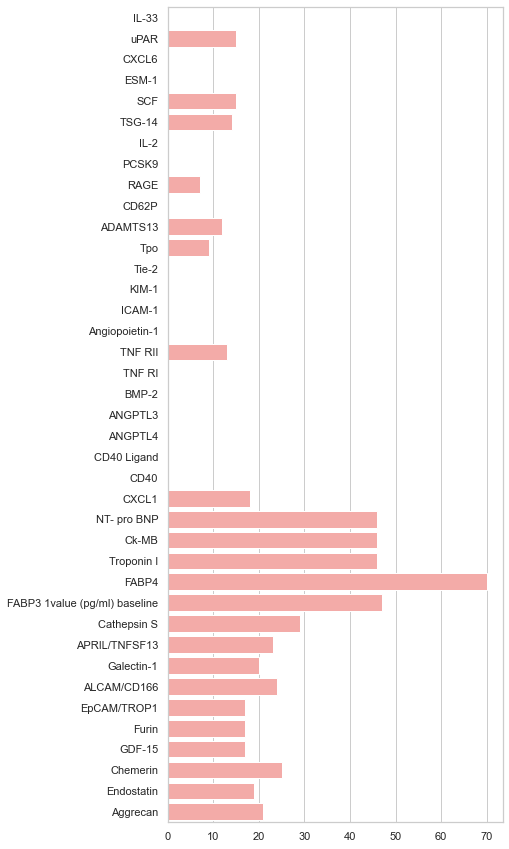

In [123]:
## missing value analysis on proteins

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

prot_miss = df[proteins].isna().sum()
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x = prot_miss.values, y = prot_miss.index,
            label="Number of missing in protein vars", color="r")
plt.show()

In [124]:
### impute with mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'mean')

X = imputer.fit_transform(df[proteins])
X = pd.DataFrame(X, columns=proteins)

### correlation analysis

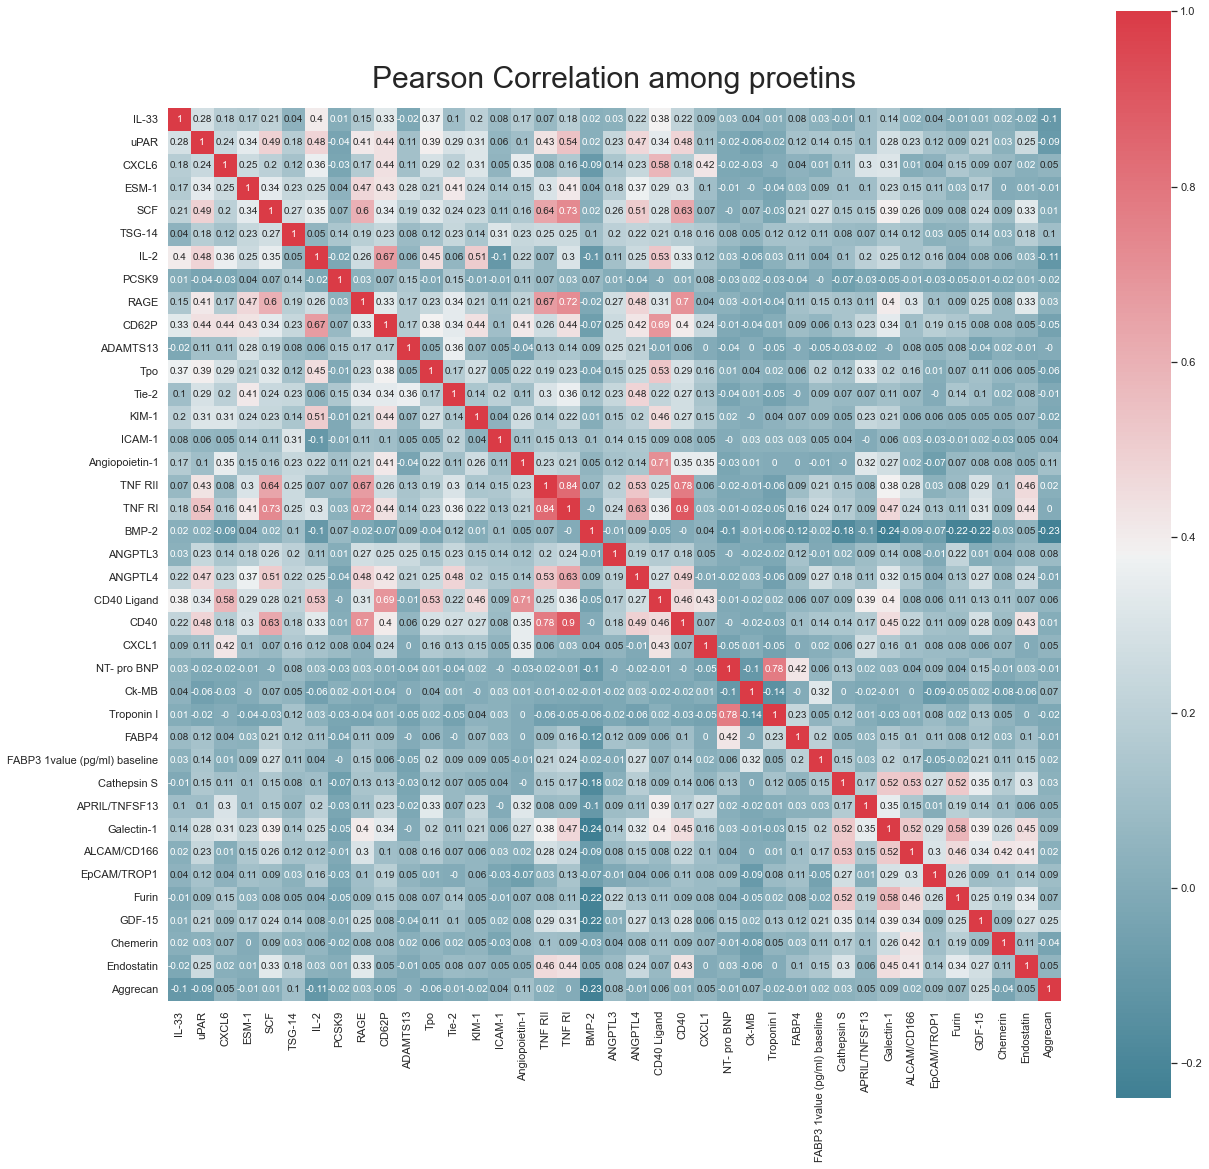

In [125]:
fig, ax = plt.subplots(figsize=(20, 20))
corr = X.corr().round(2)
ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True, annot_kws={"fontsize":10})
ax.set_title("Pearson Correlation among proetins", fontsize = 30, pad = 20)
plt.show()
# plt.savefig('./reports/hq.png', format='png', dpi=300)

In [126]:
from scipy.stats import ttest_ind, levene

df_test = pd.concat([X, df[target]], axis= 1)
print(df_test.shape)
print("target\n", df[target].value_counts())
pval = []
for protein in proteins:
    grp1 = df_test.loc[df_test.hasPAD == 1, protein]
    grp2 = df_test.loc[df_test.hasPAD == 0, protein]
    # print("Protein {} has variance test p-value: {:.2f} ".format(protein, levene(grp1, grp2)[1]))
    pval.append(ttest_ind(grp1, grp2, equal_var=False)[1])

t_test = pd.DataFrame(pval, index=proteins, columns=["p_value"])
t_test["result"] = t_test["p_value"] < 0.05
t_test.round(8).sort_values("p_value")
### The proteins with p-value less than 0.05 show significant difference between means among two groups

(461, 40)
target
 hasPAD
1         295
0         166
dtype: int64


,p_value,result
GDF-15,0.000000,True
FABP3 1value (pg/ml) baseline,0.000000,True
Endostatin,0.000024,True
TNF RII,0.000034,True
ANGPTL4,0.000073,True
SCF,0.000319,True
uPAR,0.000845,True
TNF RI,0.001371,True
Cathepsin S,0.001827,True
Tpo,0.002588,True


In [127]:
# design_report = ProfileReport(df_test)
# design_report.to_file(output_file='./reports/pd_profile_report_proteins.html')

## Looking at Clinical Vars

In [131]:
df[clinical].isna().sum()

Age                          2
Gender                       2
Hypertension                 3
Hyperchol                    3
Diabetes                     1
Renal Insufficiency          2
Dialysis                     2
Smoking Hx                   5
Congestive heart failure     6
Cornary artery disease       7
Stroke/TIA                  18
statin                      27
ACEi/ARB                    28
B-bl                        29
CCB                         28
HCTZ, Lasix                 29
Insulin                     30
oral hypoglyc               34
dtype: int64

In [132]:
df.loc[df.Age.isna(), clinical]

,Age,Gender,Hypertension,Hyperchol,Diabetes,Renal Insufficiency,Dialysis,Smoking Hx,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc
146,NaN,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
319,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [133]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range= (0,1))
X_sc = scaler.fit_transform(X)

In [139]:
## simple logistic regression on file
from sklearn.linear_model import LogisticRegression
X = X_sc
y = df[target].squeeze()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify= y,
     test_size=0.25, random_state=27)
model_LR = LogisticRegression(random_state=42)
model_LR.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [152]:
y_pred = model_LR.predict(X_test)
y_pred_proba = model_LR.predict_proba(X_test)[:,1]
print(*[metrics.accuracy_score(y_test, y_pred),
metrics.roc_auc_score(y_test, y_pred_proba)], sep = "\n")

0.7327586206896551
0.7686615186615187


In [153]:
##just on these proteins an AUC of 0.76 without the correlation or clinical vars is remarkable